In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PyEMD import EMD
import random
from sklearn.cross_decomposition import CCA
from scipy.signal import welch
from scipy.stats import kurtosis, skew
from sklearn.feature_selection import SelectKBest, mutual_info_classif

In [40]:
random_shift = random.randint(-125, 125)
center_idx = 0     
center_idx += random_shift
print(center_idx)

17


In [44]:
# Load data
combined_data = pd.read_csv("ShawnTrainingData/combined_data.csv").values.astype(np.float32)
training_data = pd.read_csv("ShawnTrainingData/training_data.csv").values.astype(np.int64)

# Settings
sampling_rate = 250
window_sec = 2
window_size = sampling_rate * window_sec
half_window = window_size // 2

# Feature extraction functions
def compute_bandpower(data, fs, band):
    freqs, psd = welch(data, fs=fs, nperseg=fs//2)
    idx_band = np.logical_and(freqs >= band[0], freqs <= band[1])
    return np.trapz(psd[idx_band], freqs[idx_band])

def compute_rms(x):
    return np.sqrt(np.mean(np.square(x)))

def compute_hjorth_params(x):
    first_deriv = np.diff(x)
    second_deriv = np.diff(first_deriv)
    var_zero = np.var(x)
    var_d1 = np.var(first_deriv)
    var_d2 = np.var(second_deriv)
    mobility = np.sqrt(var_d1 / var_zero) if var_zero != 0 else 0
    complexity = np.sqrt(var_d2 / var_d1) if var_d1 != 0 else 0
    return mobility, complexity

# Generate feature names
base_features = ['band1', 'band2','band3', 'band4', 'rms', 'mobility', 'complexity', 'kurtosis', 'skewness']
feature_names = [f"{feat}_ch{ch+1}" for ch in range(4) for feat in base_features]

# Extract features from all training samples
X, y = [], []

for class_label, center_idx in training_data:
    start = max(0, center_idx - half_window)
    end = min(len(combined_data), center_idx + half_window)
    window = combined_data[start:end, :4]

    # Pad if window is short
    if end - start < window_size:
        padded = np.zeros((window_size, 4), dtype=np.float32)
        offset = max(0, - (center_idx - half_window))
        padded[offset:offset + (end - start)] = window
        window = padded

    features = []
    for ch in range(4):
        signal = window[:, ch]
        signal = signal / np.max(np.abs(signal)) if np.max(np.abs(signal)) != 0 else signal  # normalize to [-1, 1]
        band1 = compute_bandpower(signal, fs=sampling_rate, band=(8, 10))
        band2 = compute_bandpower(signal, fs=sampling_rate, band=(10, 12))
        band3 = compute_bandpower(signal, fs=sampling_rate, band=(12, 14))
        band4 = compute_bandpower(signal, fs=sampling_rate, band=(12, 15))
        rms_val = compute_rms(signal)
        mob, comp = compute_hjorth_params(signal)
        kurt = kurtosis(signal)
        skew_val = skew(signal)
        features.extend([band1, band2, rms_val, mob, comp, kurt, skew_val])
    X.append(features)
    y.append(class_label)

X = np.array(X)
y = np.array(y)

# Feature selection
selector = SelectKBest(score_func=mutual_info_classif, k=10)
X_selected = selector.fit_transform(X, y)
top_indices = selector.get_support(indices=True)
top_feature_names = [feature_names[i] for i in top_indices]
feature_scores = selector.scores_

top_features_with_scores = [(feature_names[i], feature_scores[i]) for i in top_indices]

top_features_with_scores

[('band4_ch1', 0.2087974842779694),
 ('rms_ch1', 0.3054902928790808),
 ('kurtosis_ch1', 0.2186693256097012),
 ('skewness_ch1', 0.2344448625995179),
 ('band2_ch2', 0.29298646732618616),
 ('band4_ch2', 0.20384934002227828),
 ('skewness_ch2', 0.2618407220677468),
 ('band1_ch3', 0.5963843153841655),
 ('complexity_ch3', 0.2779163099950548),
 ('kurtosis_ch3', 0.3656470195015342)]

In [ ]:
# Load data
combined_data = pd.read_csv("ShawnTrainingData/combined_data.csv").values.astype(np.float32)
training_data = pd.read_csv("ShawnTrainingData/training_data.csv").values.astype(np.int64)

# Settings
sampling_rate = 250
window_sec = 2
window_size = sampling_rate * window_sec
half_window = window_size // 2

# Feature extraction functions
def compute_bandpower(data, fs, band):
    freqs, psd = welch(data, fs=fs, nperseg=fs//2)
    idx_band = np.logical_and(freqs >= band[0], freqs <= band[1])
    return np.trapz(psd[idx_band], freqs[idx_band])

def compute_rms(x):
    return np.sqrt(np.mean(np.square(x)))

def compute_hjorth_params(x):
    first_deriv = np.diff(x)
    second_deriv = np.diff(first_deriv)
    var_zero = np.var(x)
    var_d1 = np.var(first_deriv)
    var_d2 = np.var(second_deriv)
    mobility = np.sqrt(var_d1 / var_zero) if var_zero != 0 else 0
    complexity = np.sqrt(var_d2 / var_d1) if var_d1 != 0 else 0
    return mobility, complexity

# Generate feature names
base_features = ['alpha', 'beta', 'rms', 'mobility', 'complexity', 'kurtosis', 'skewness']
feature_names = [f"{feat}_ch{ch+1}" for ch in range(4) for feat in base_features]

# Extract features from all training samples
X, y = [], []

for class_label, center_idx in training_data:
    start = max(0, center_idx - half_window)
    end = min(len(combined_data), center_idx + half_window)
    window = combined_data[start:end, :4]

    # Pad if window is short
    if end - start < window_size:
        padded = np.zeros((window_size, 4), dtype=np.float32)
        offset = max(0, - (center_idx - half_window))
        padded[offset:offset + (end - start)] = window
        window = padded

    features = []
    for ch in range(4):
        signal = window[:, ch]
        signal = signal / np.max(np.abs(signal)) if np.max(np.abs(signal)) != 0 else signal  # normalize to [-1, 1]
        alpha = compute_bandpower(signal, fs=sampling_rate, band=(8, 13))
        beta = compute_bandpower(signal, fs=sampling_rate, band=(13, 30))
        rms_val = compute_rms(signal)
        mob, comp = compute_hjorth_params(signal)
        kurt = kurtosis(signal)
        skew_val = skew(signal)
        features.extend([alpha, beta, rms_val, mob, comp, kurt, skew_val])
    X.append(features)
    y.append(class_label)

X = np.array(X)
y = np.array(y)

# Feature selection
selector = SelectKBest(score_func=mutual_info_classif, k=10)
X_selected = selector.fit_transform(X, y)
top_indices = selector.get_support(indices=True)
top_feature_names = [feature_names[i] for i in top_indices]
feature_scores = selector.scores_

top_features_with_scores = [(feature_names[i], feature_scores[i]) for i in top_indices]

top_features_with_scores

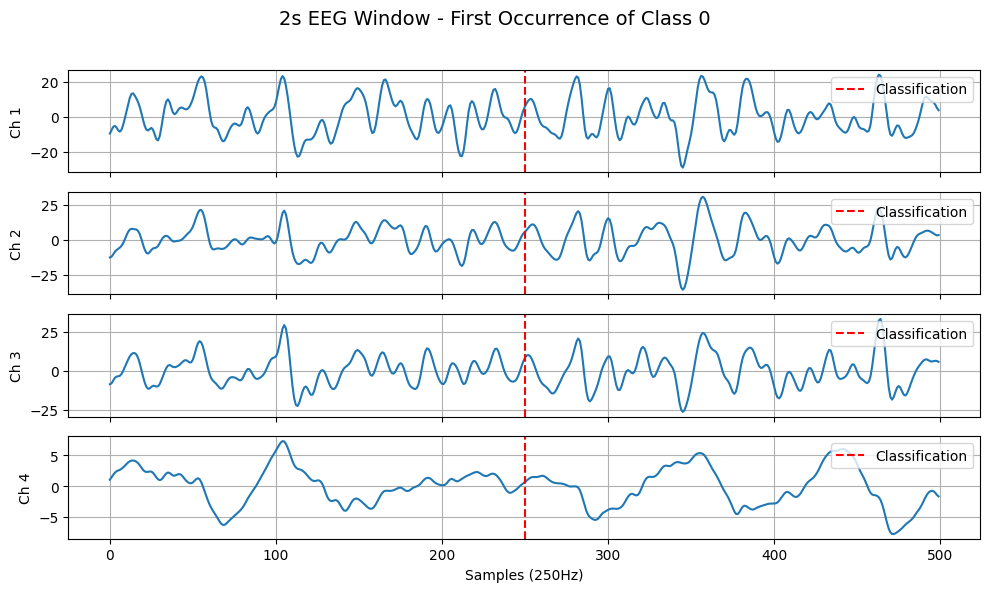

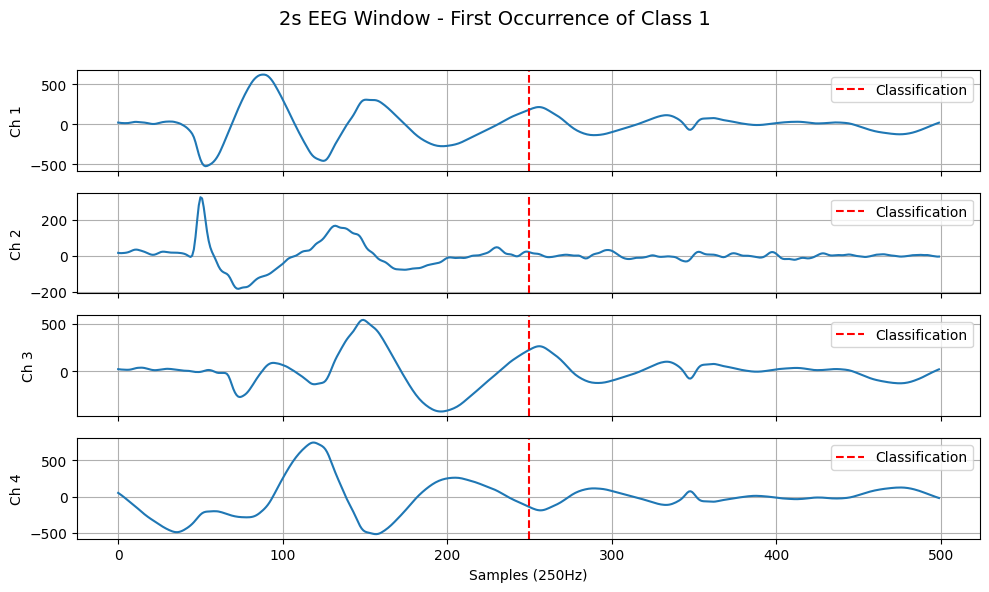

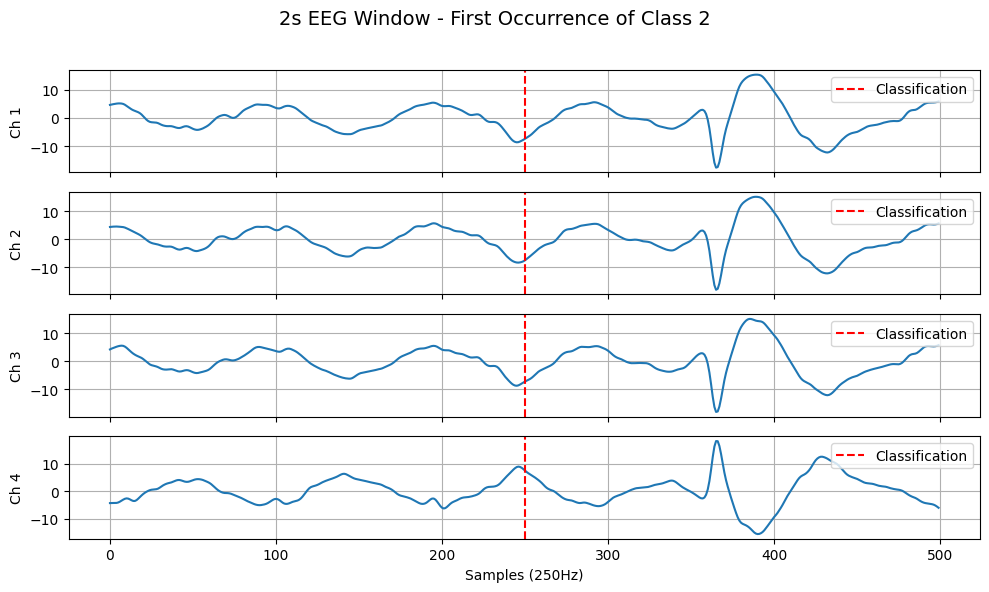

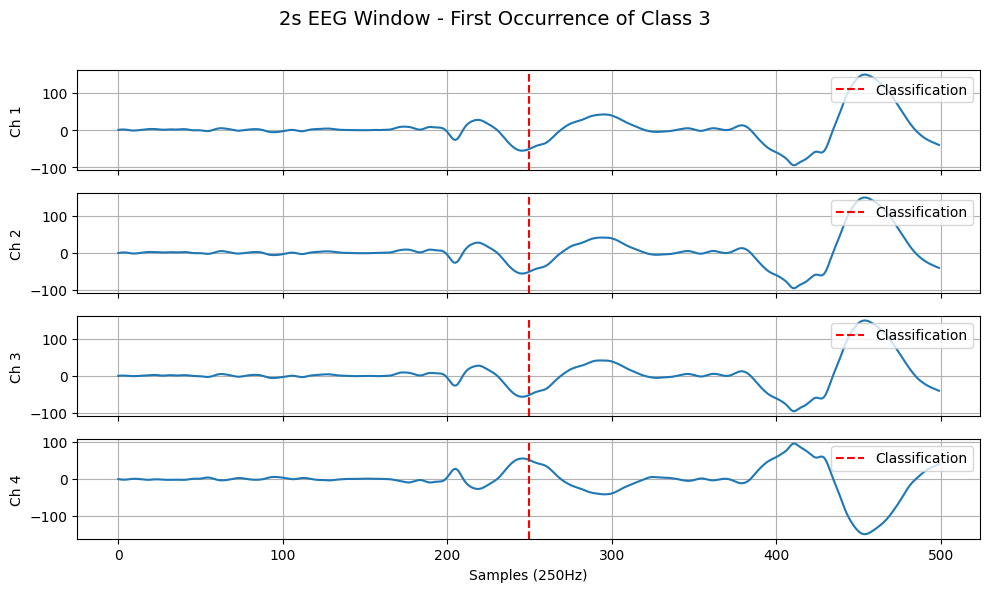

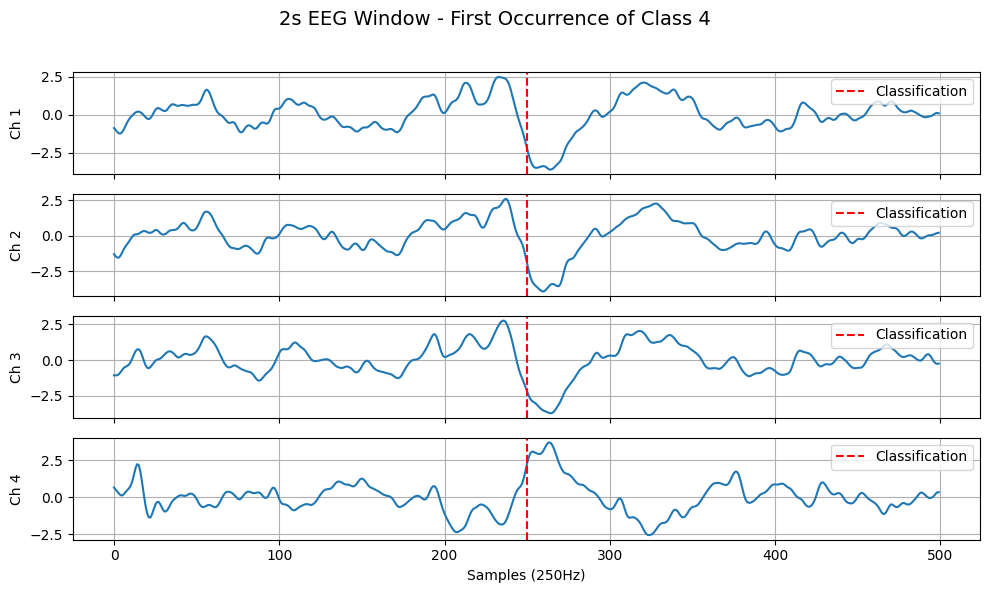

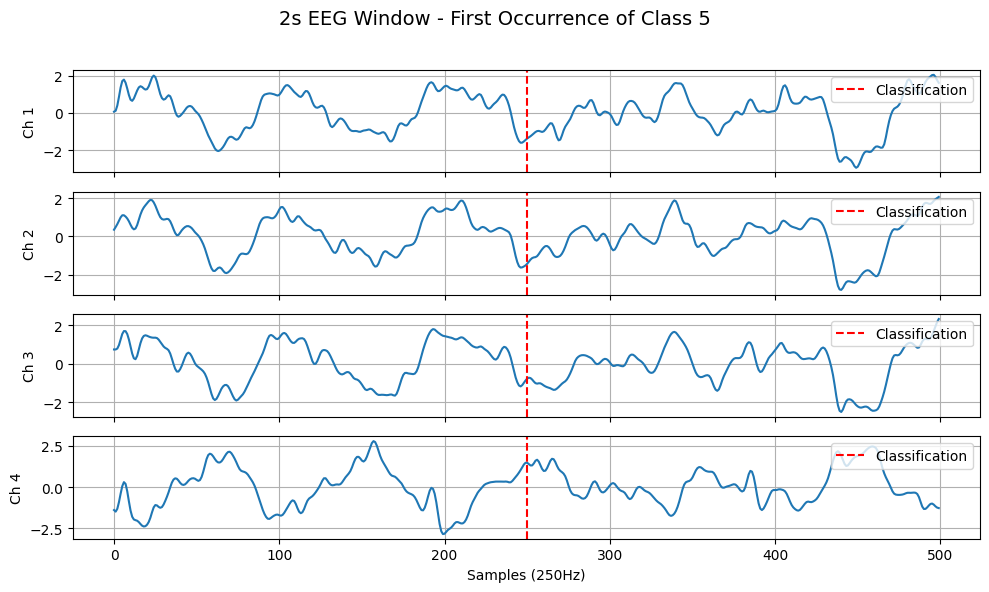

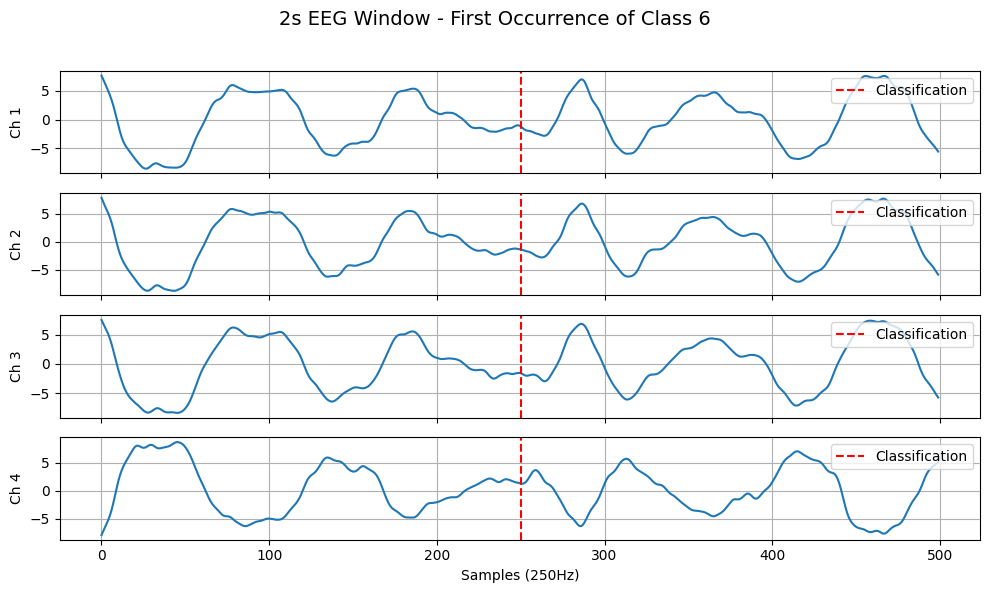

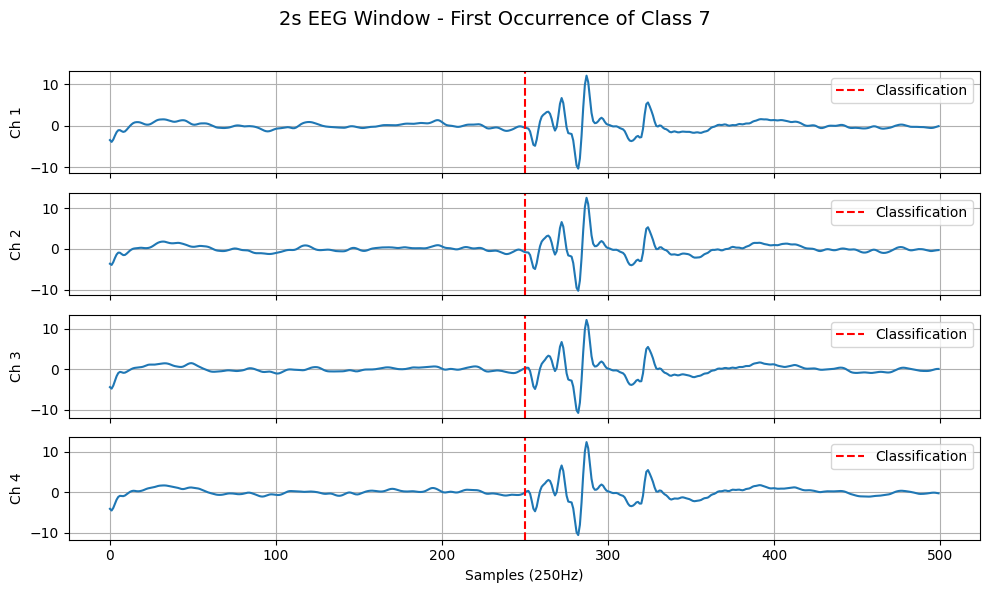

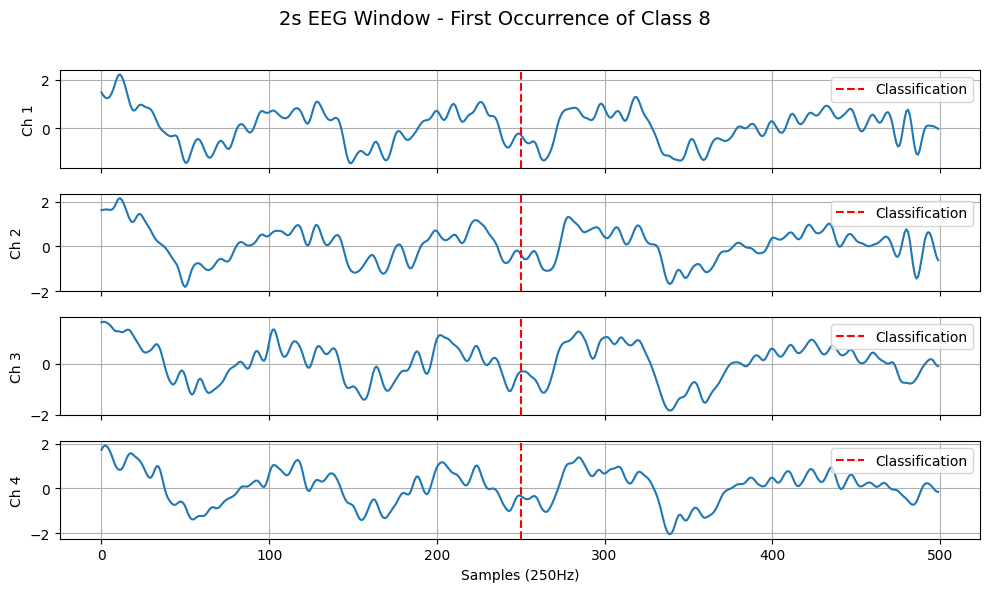

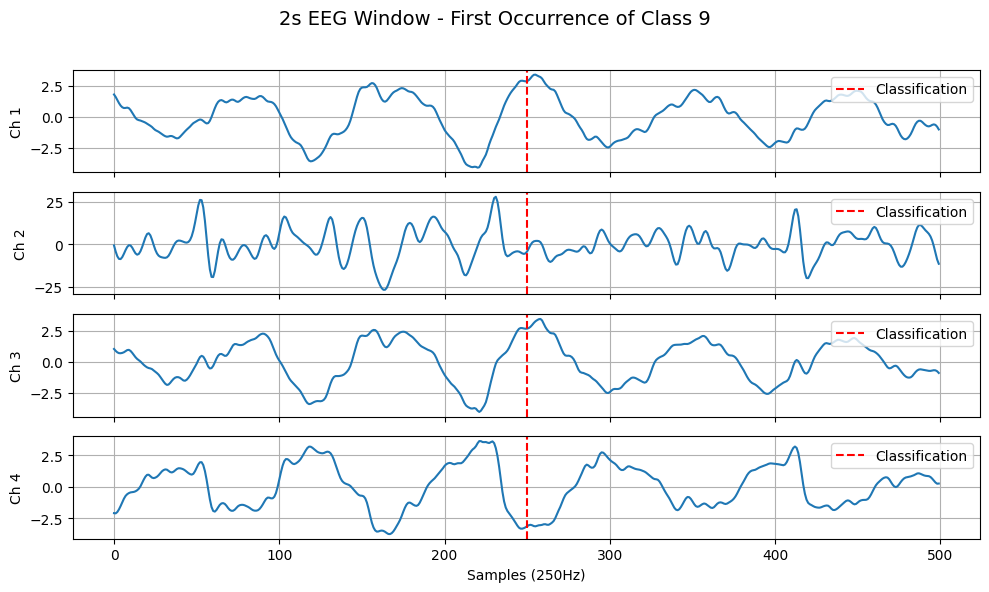

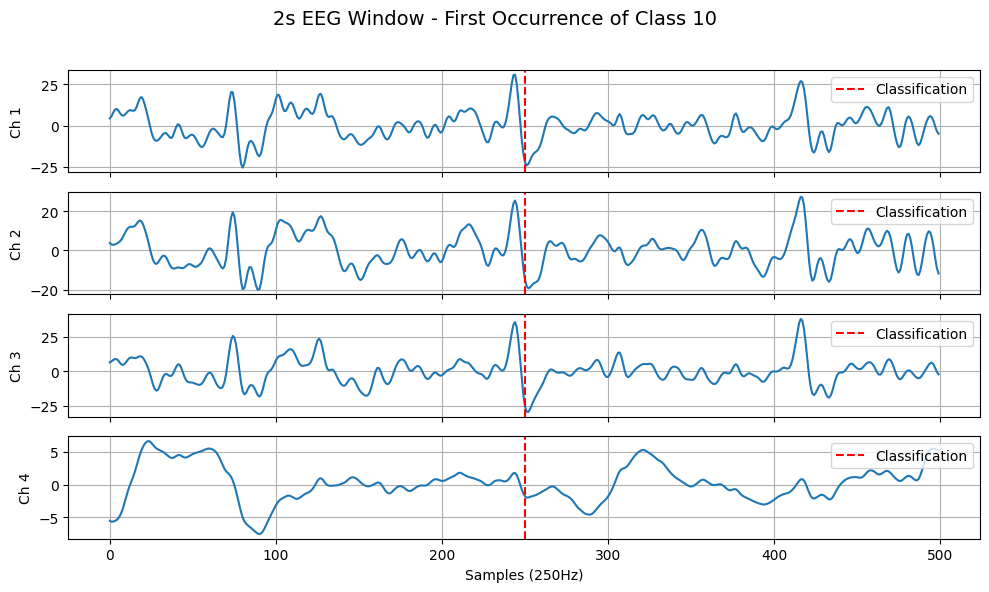

In [30]:
# Load files
classification_path = "NickTrainingData/training_data.csv"
data_path = "NickTrainingData/combined_data.csv"

classification = pd.read_csv(classification_path).values.astype(np.int64)
data = pd.read_csv(data_path).values.astype(np.float32)

# EEG & class info
channel_data = data[:, :4]
classifications_list = [0,1,2,3,4,5,6,7,8,9,10]

# Settings
sampling_rate = 250
window_size = sampling_rate * 2  # 2 seconds
half_window = window_size // 2

# Plot each class
for class_id in classifications_list:
    matches = classification[classification[:, 0] == class_id]
    if len(matches) == 0:
        print(f"Class {class_id} not found in classification data.")
        continue

    center_idx = matches[15, 1]
    start = max(0, center_idx - half_window)
    end = min(len(data), center_idx + half_window)
    window = channel_data[start:end]
    

    
    #max_abs = np.max(np.abs(window))
    #window = window / max_abs if max_abs != 0 else window

    # Plot
    fig, axes = plt.subplots(4, 1, figsize=(10, 6), sharex=True)
    fig.suptitle(f"2s EEG Window - First Occurrence of Class {class_id}", fontsize=14)

    for ch in range(4):
        axes[ch].plot(window[:, ch], color='tab:blue')
        axes[ch].axvline(x=half_window, color='red', linestyle='--', label='Classification')  # vertical line
        axes[ch].set_ylabel(f"Ch {ch+1}")
        axes[ch].grid(True)
        axes[ch].legend(loc="upper right")

    axes[-1].set_xlabel("Samples (250Hz)")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    


In [ ]:
    # --- Apply CCA ---
    X = window[:, :4]             # First 4 EEG channels
    Y = np.roll(X, shift=1, axis=0)  # Time-lagged version (shifted by 1 sample)
    cca = CCA(n_components=4)
    X_c, Y_c = cca.fit_transform(X, Y)
    cca_output = X_c  # Use canonical components as cleaned signals

    # --- Plot ---
    fig, axes = plt.subplots(4, 1, figsize=(10, 6), sharex=True)
    fig.suptitle(f"CCA-Filtered EEG Window - First Occurrence of Class {class_id}", fontsize=14)

    for ch in range(4):
        axes[ch].plot(cca_output[:, ch], color='tab:green', label='CCA Component')
        axes[ch].axvline(half_window, color='red', linestyle='--', label='Classification')
        axes[ch].set_ylabel(f"CCA {ch+1}")
        axes[ch].grid(True)
        axes[ch].legend(loc="upper right")

    axes[-1].set_xlabel("Samples (250Hz)")
    plt.tight_layout(rect=(0, 0, 1, 0.96))
    plt.show()

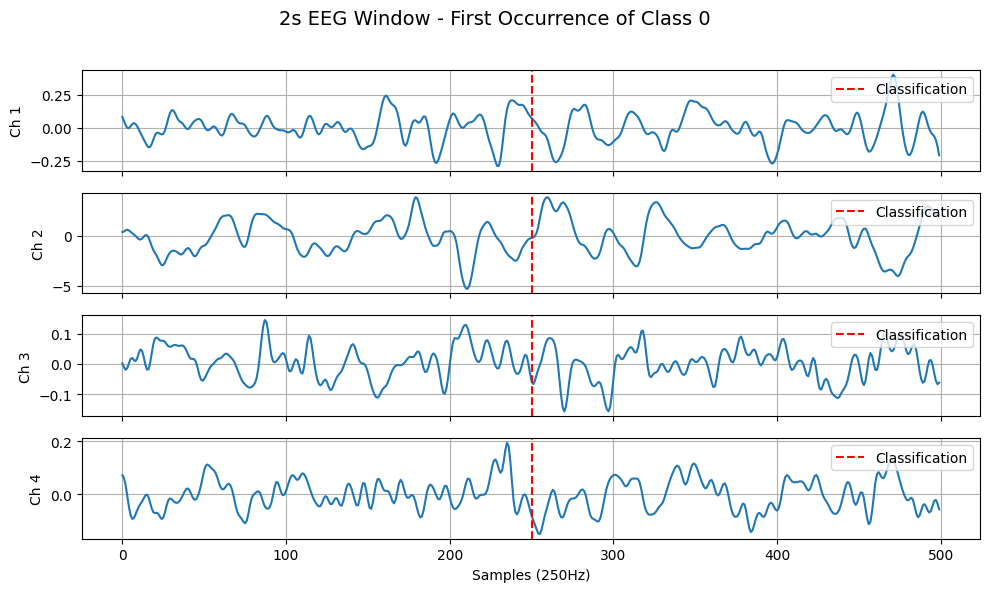

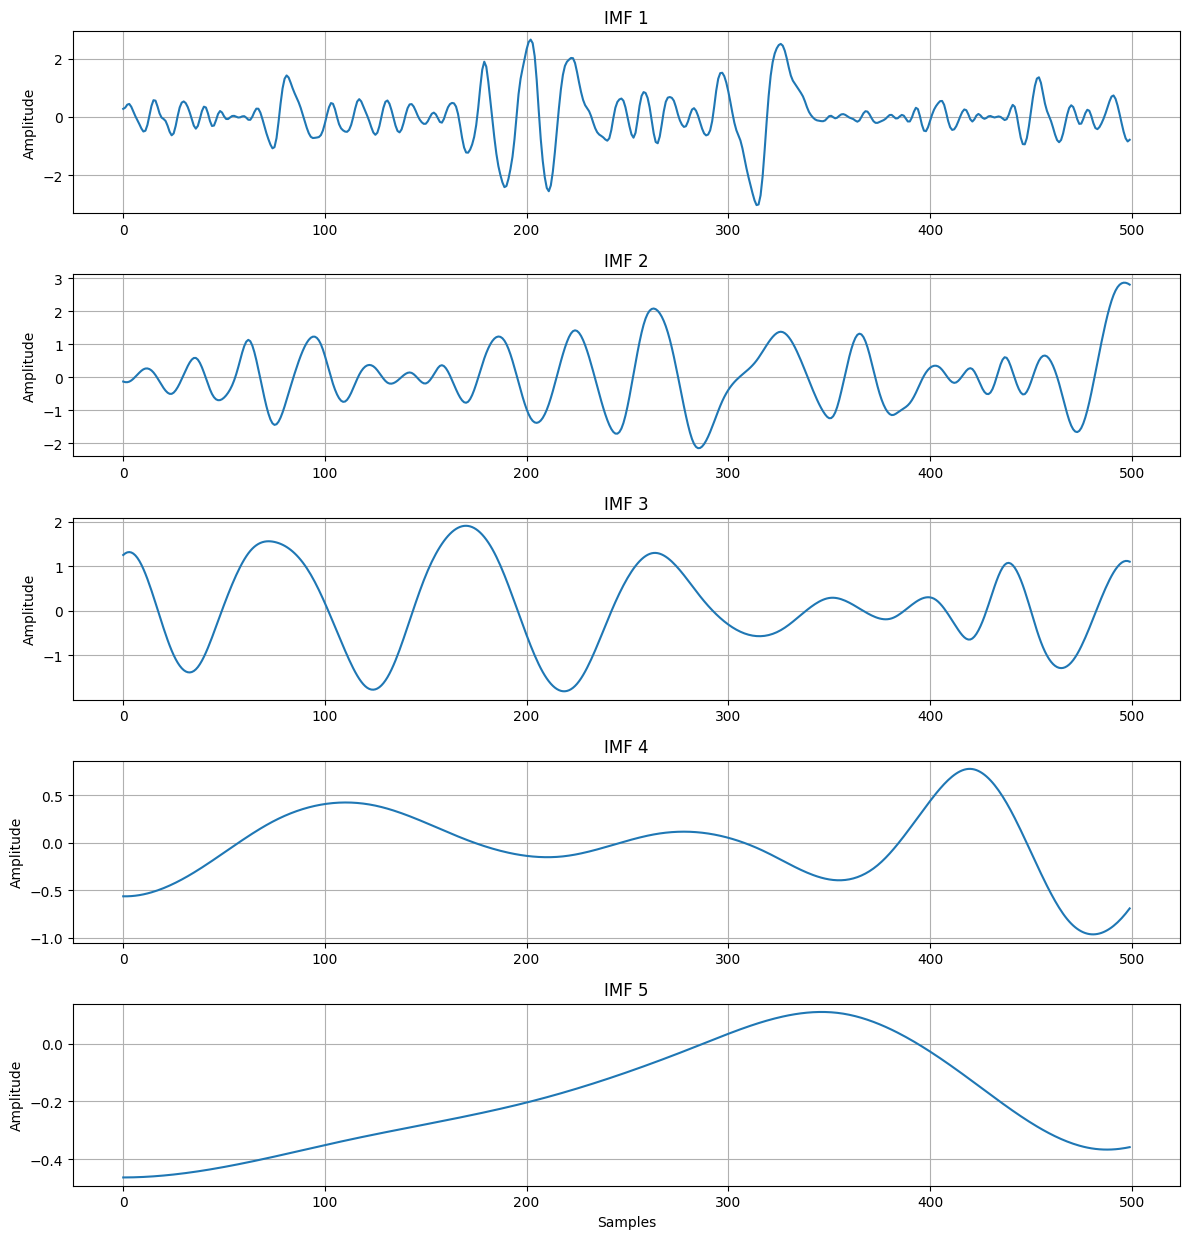

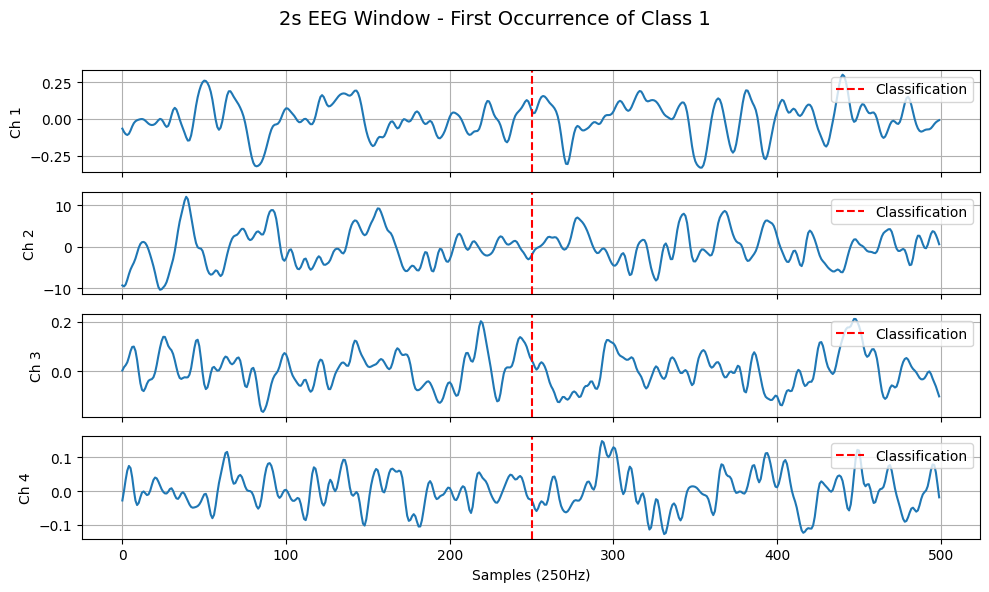

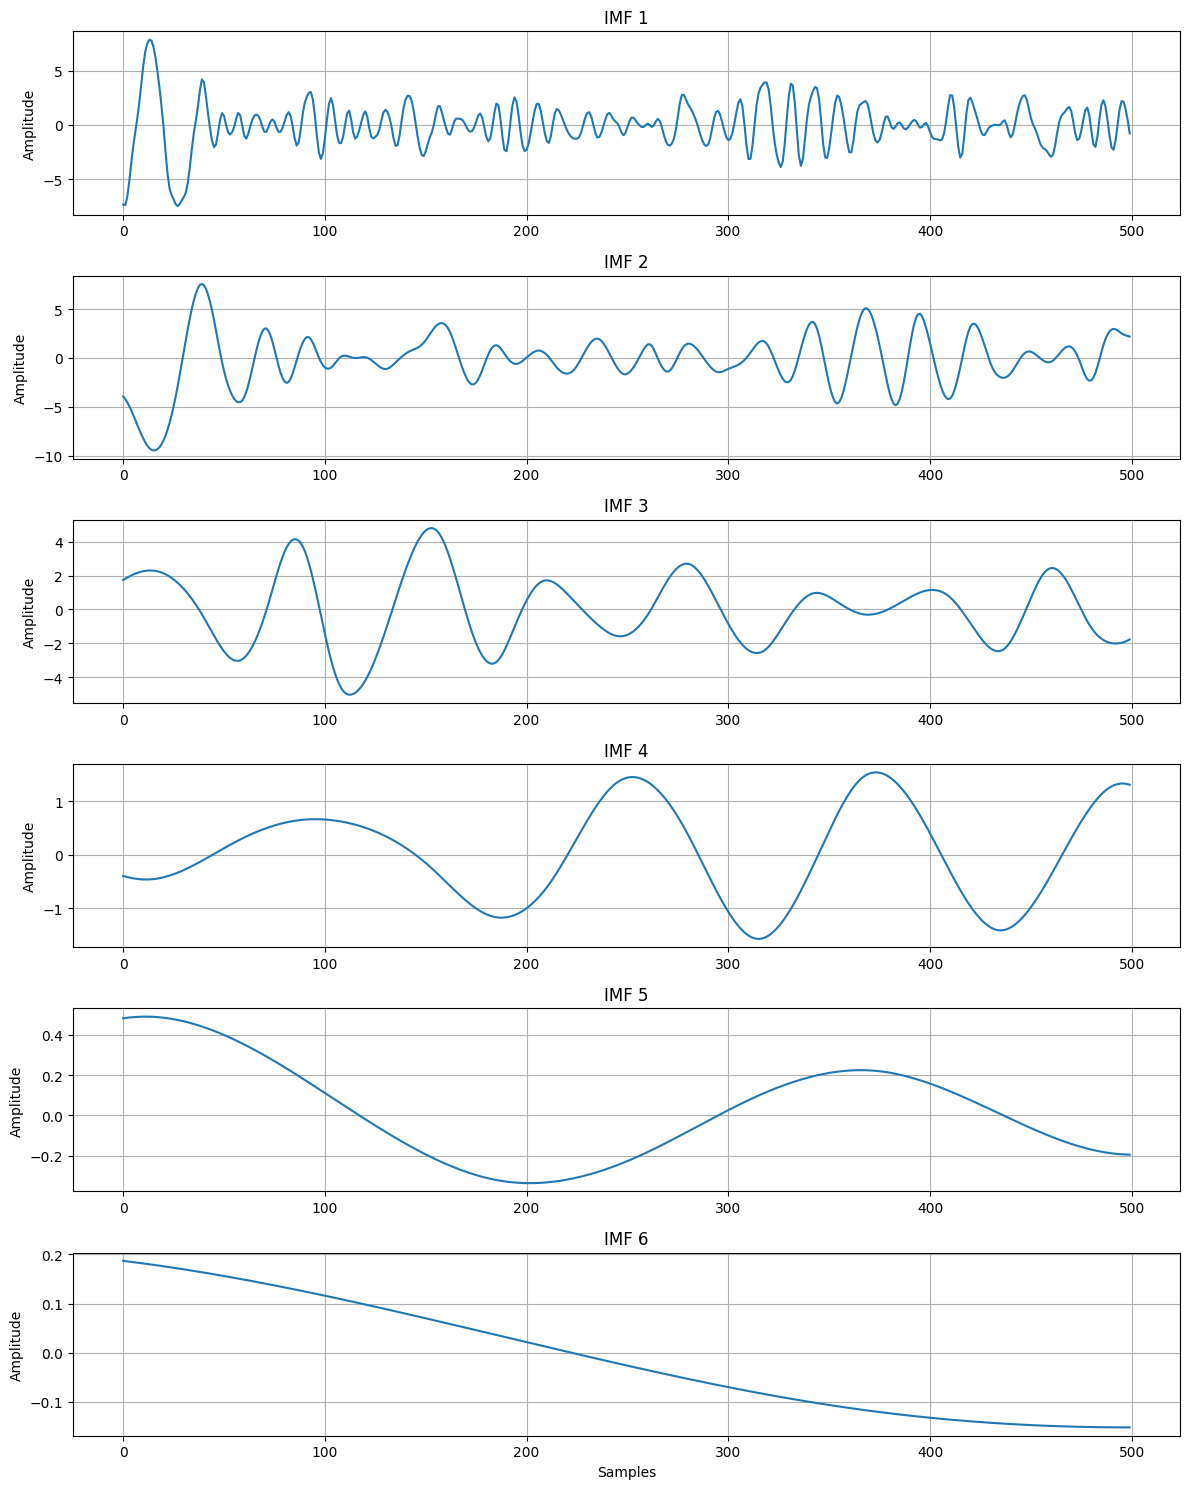

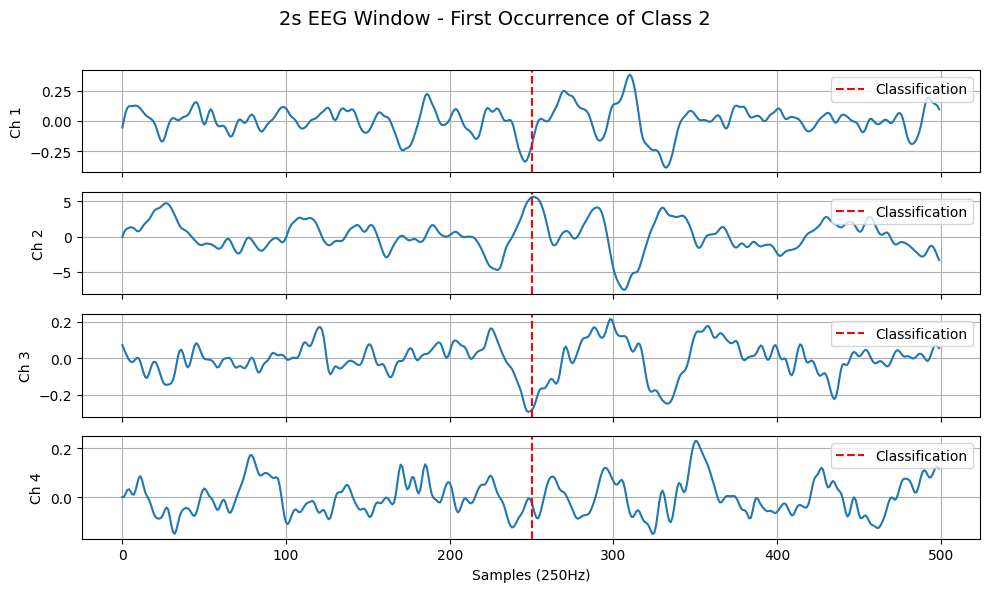

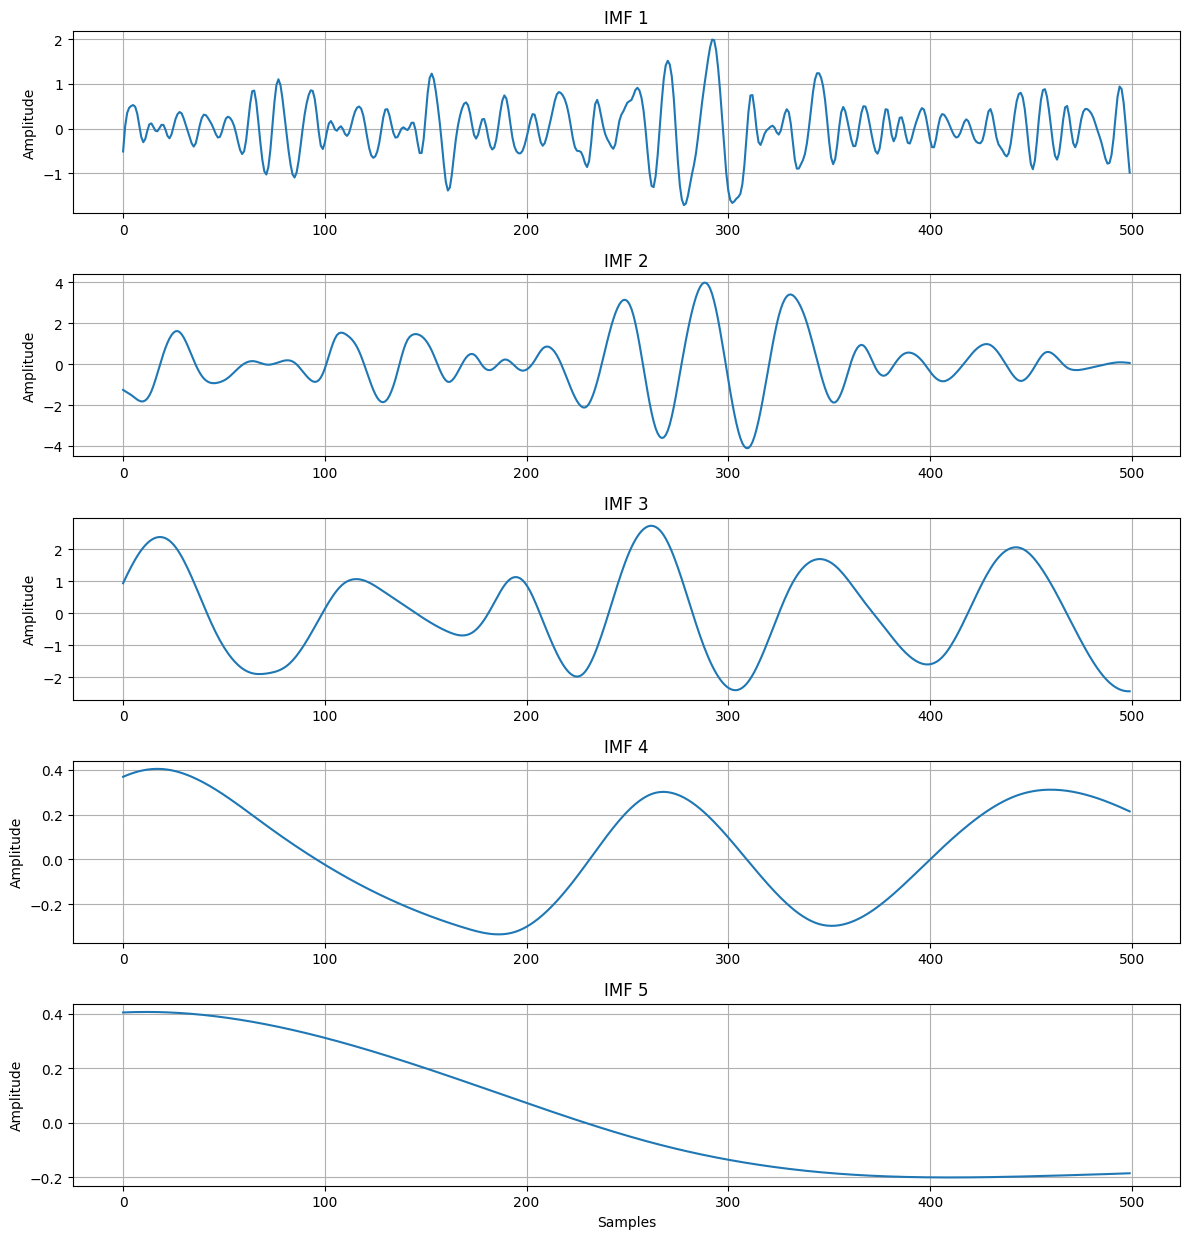

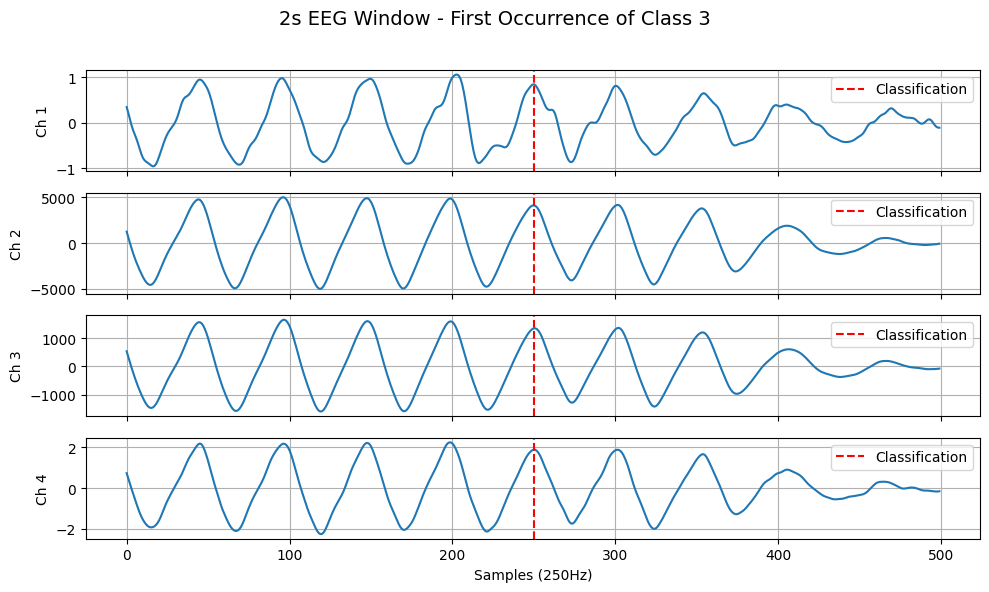

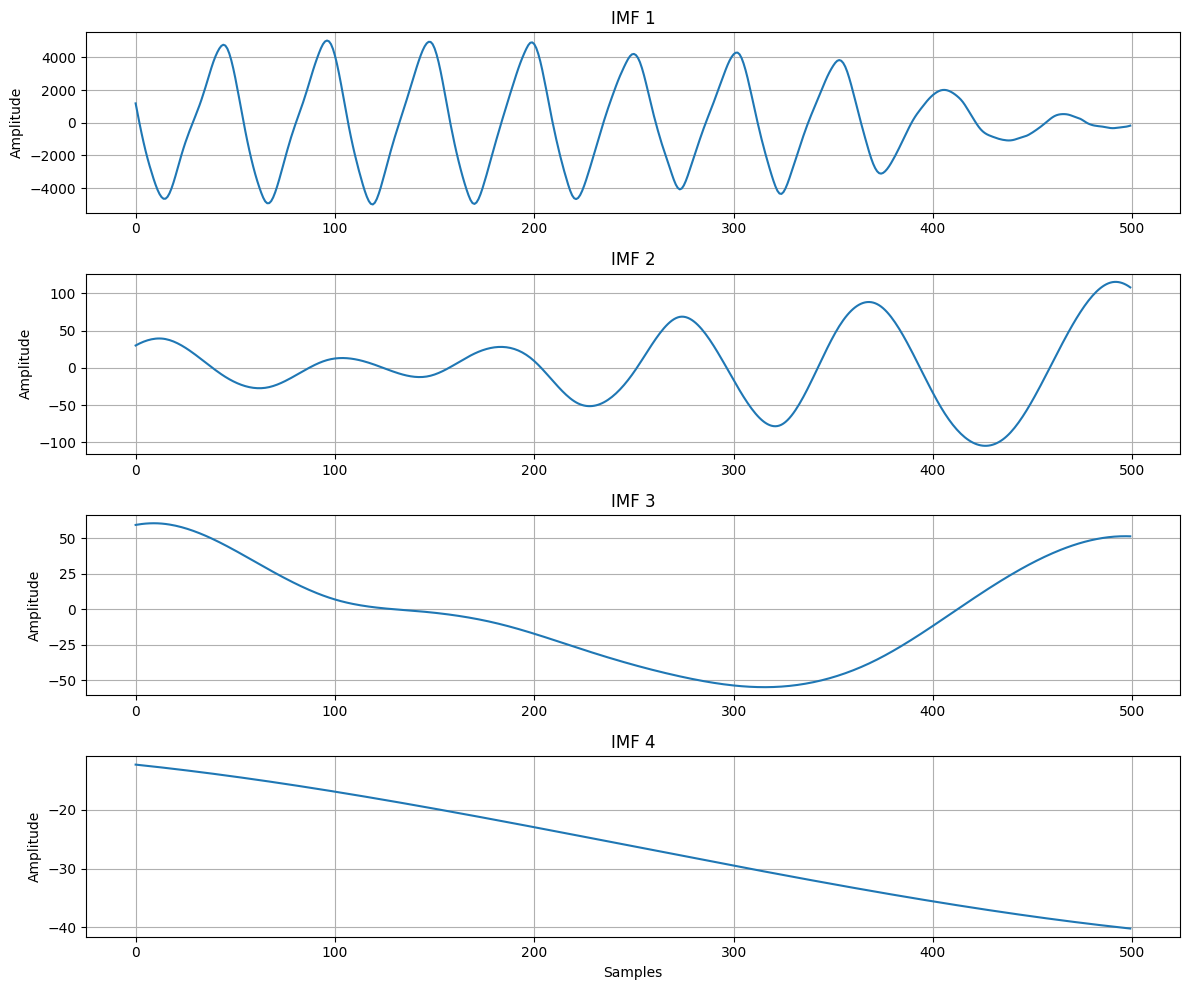

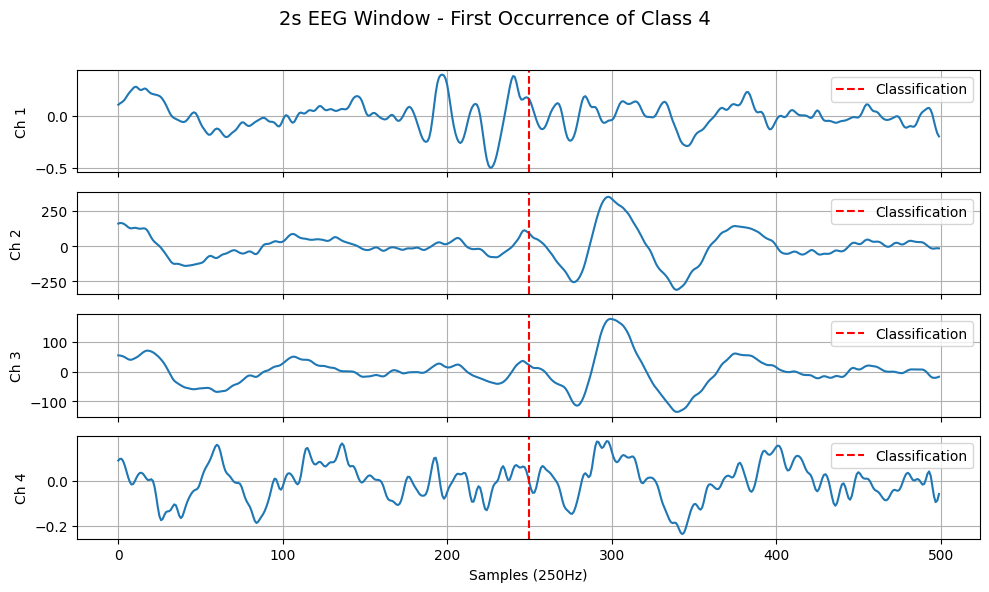

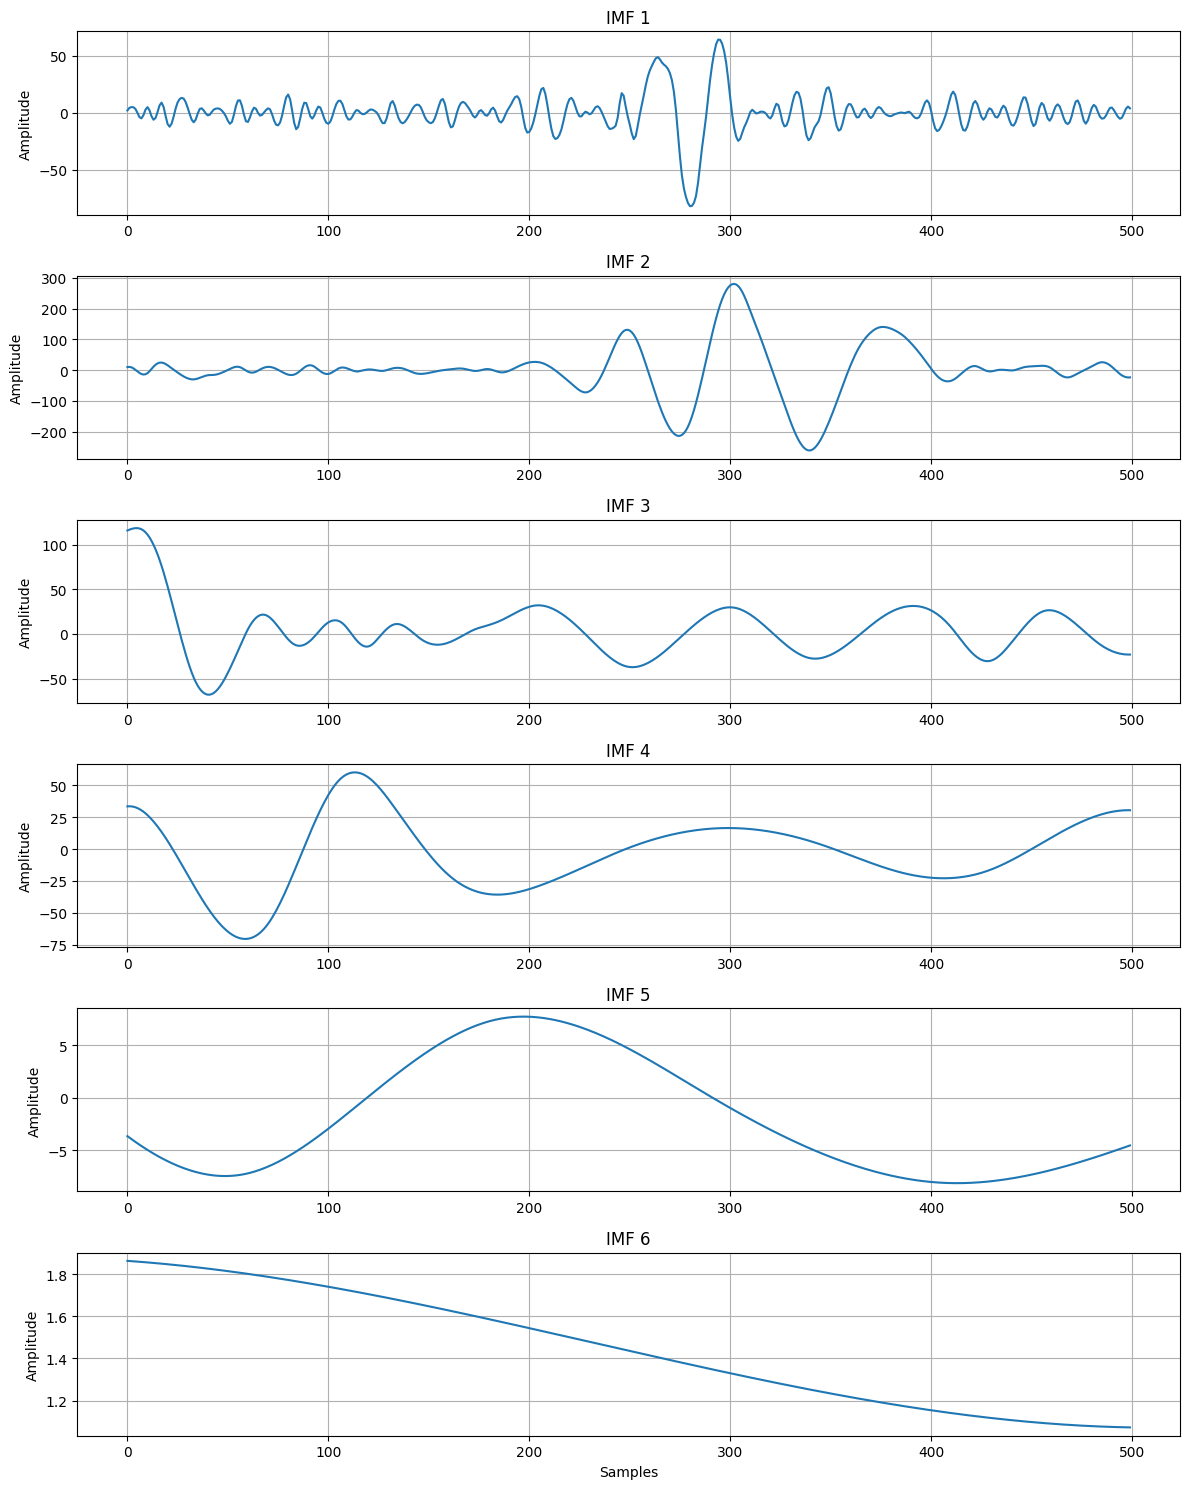

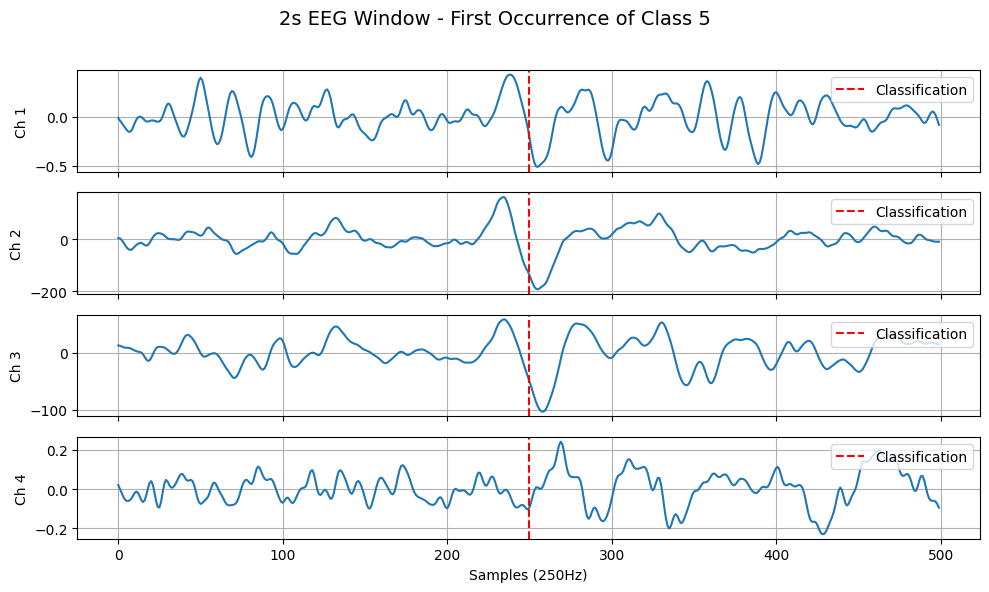

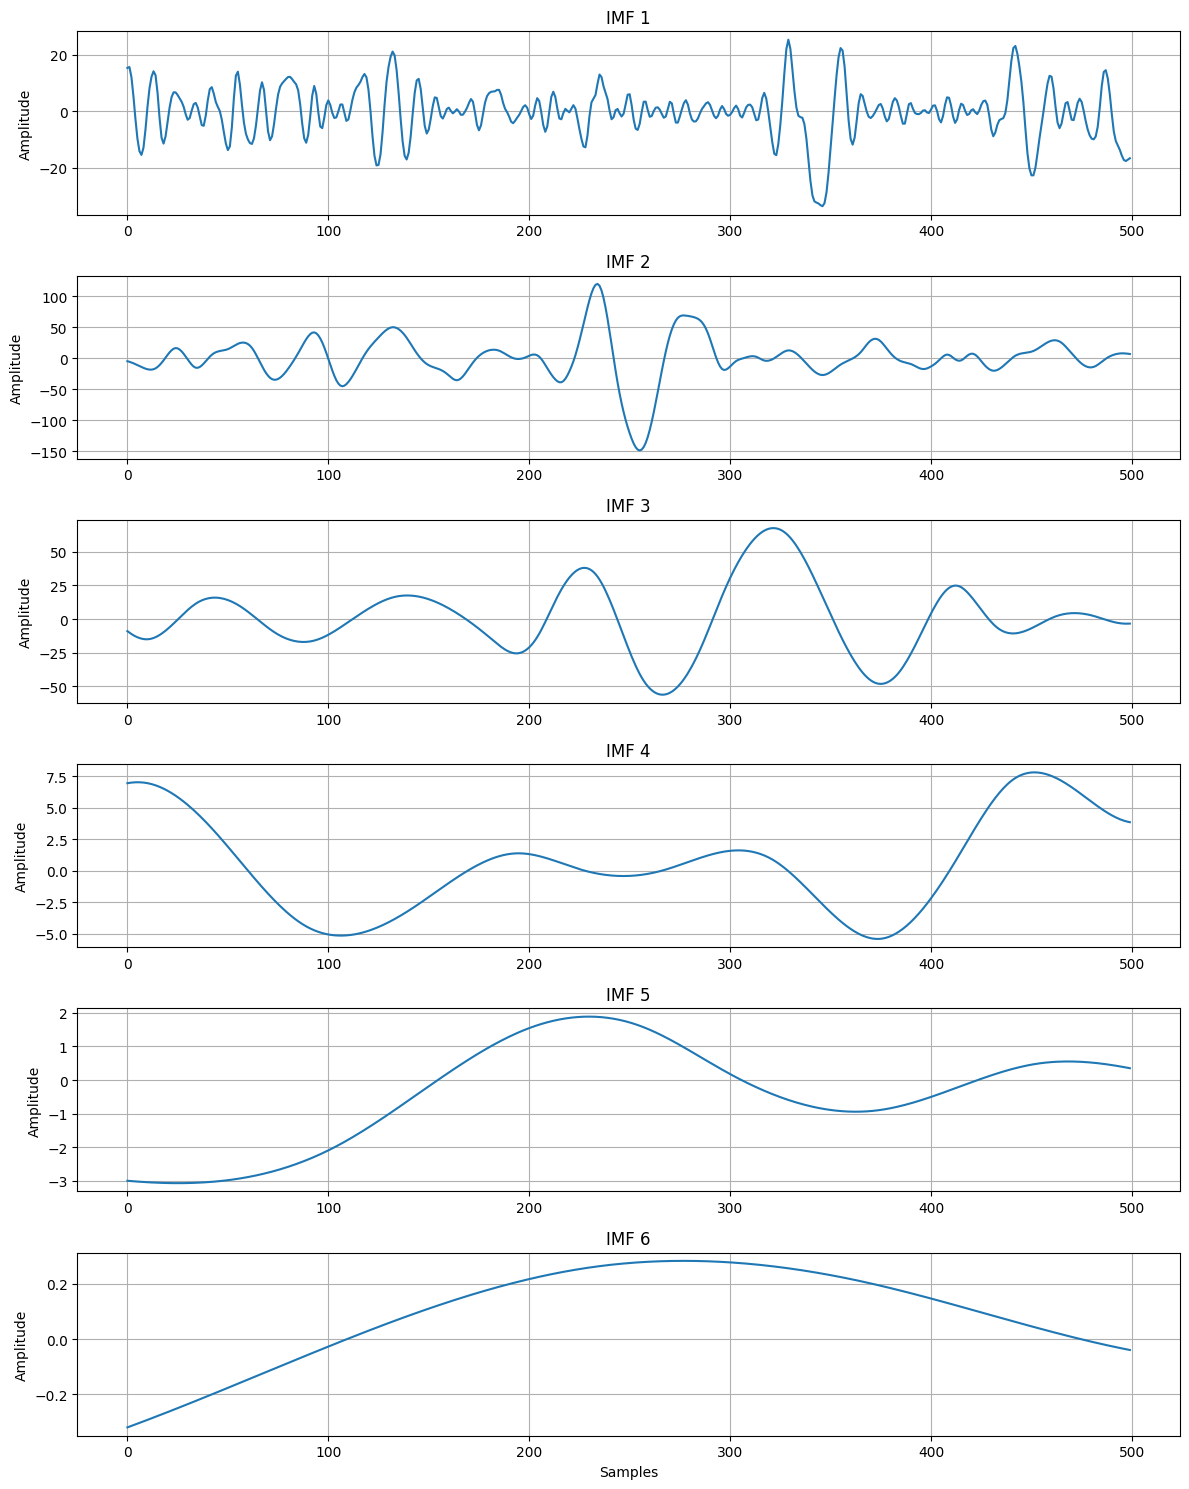

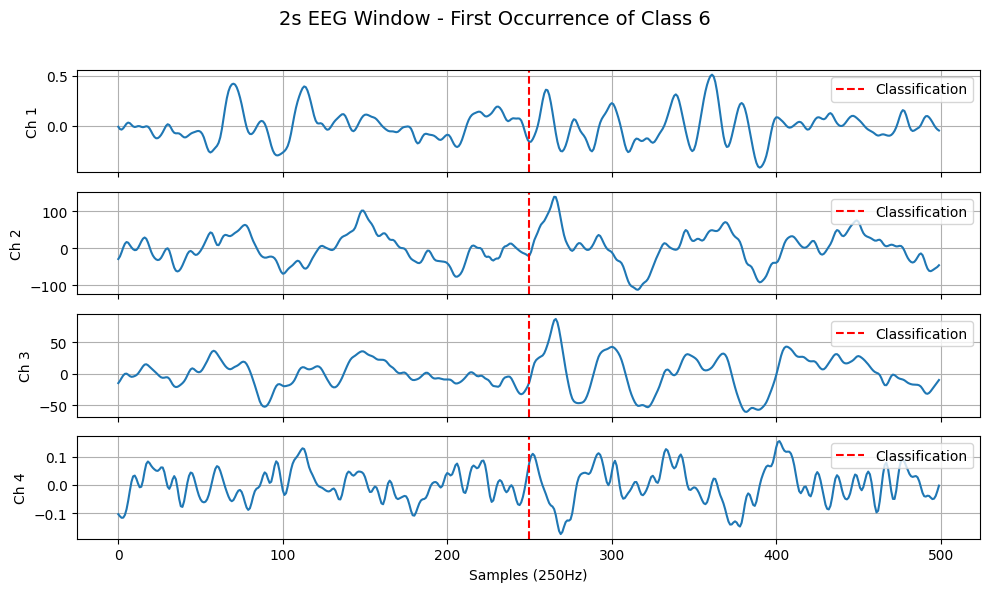

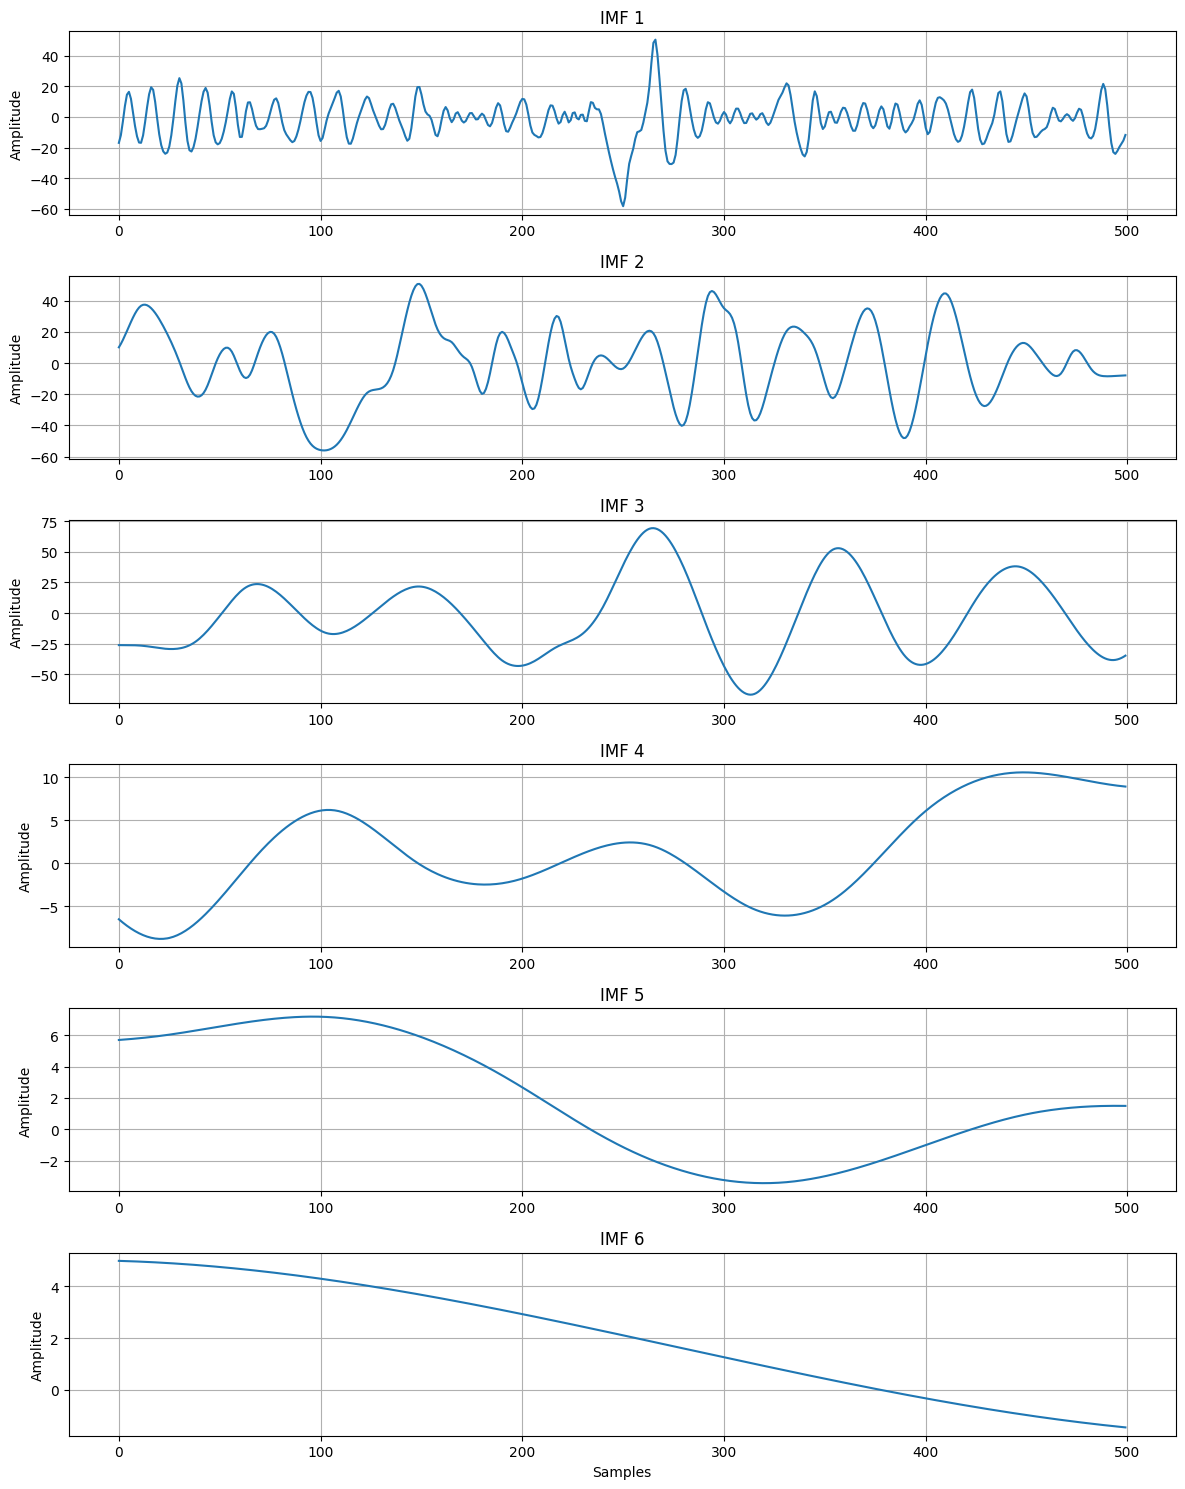

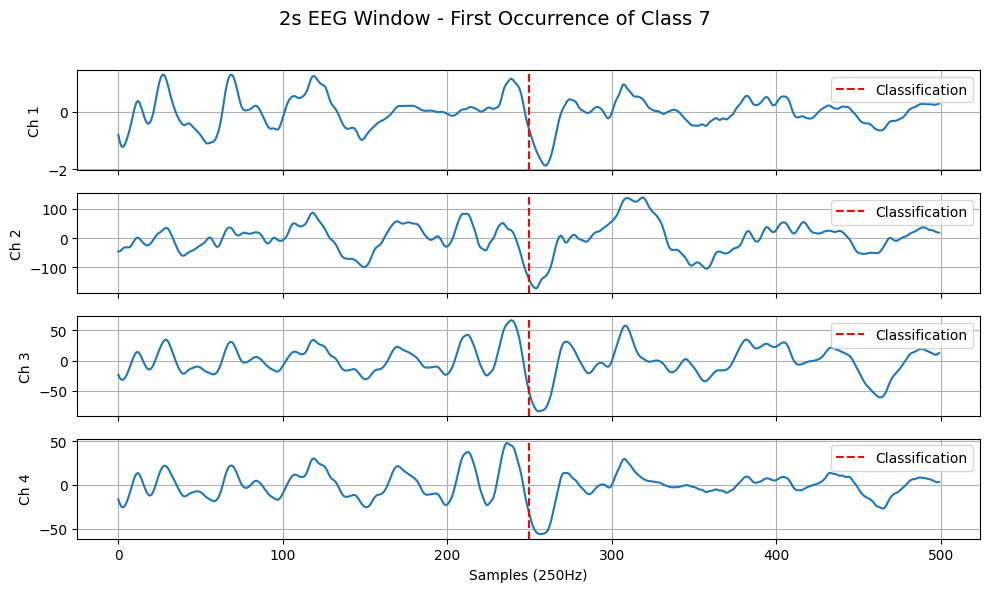

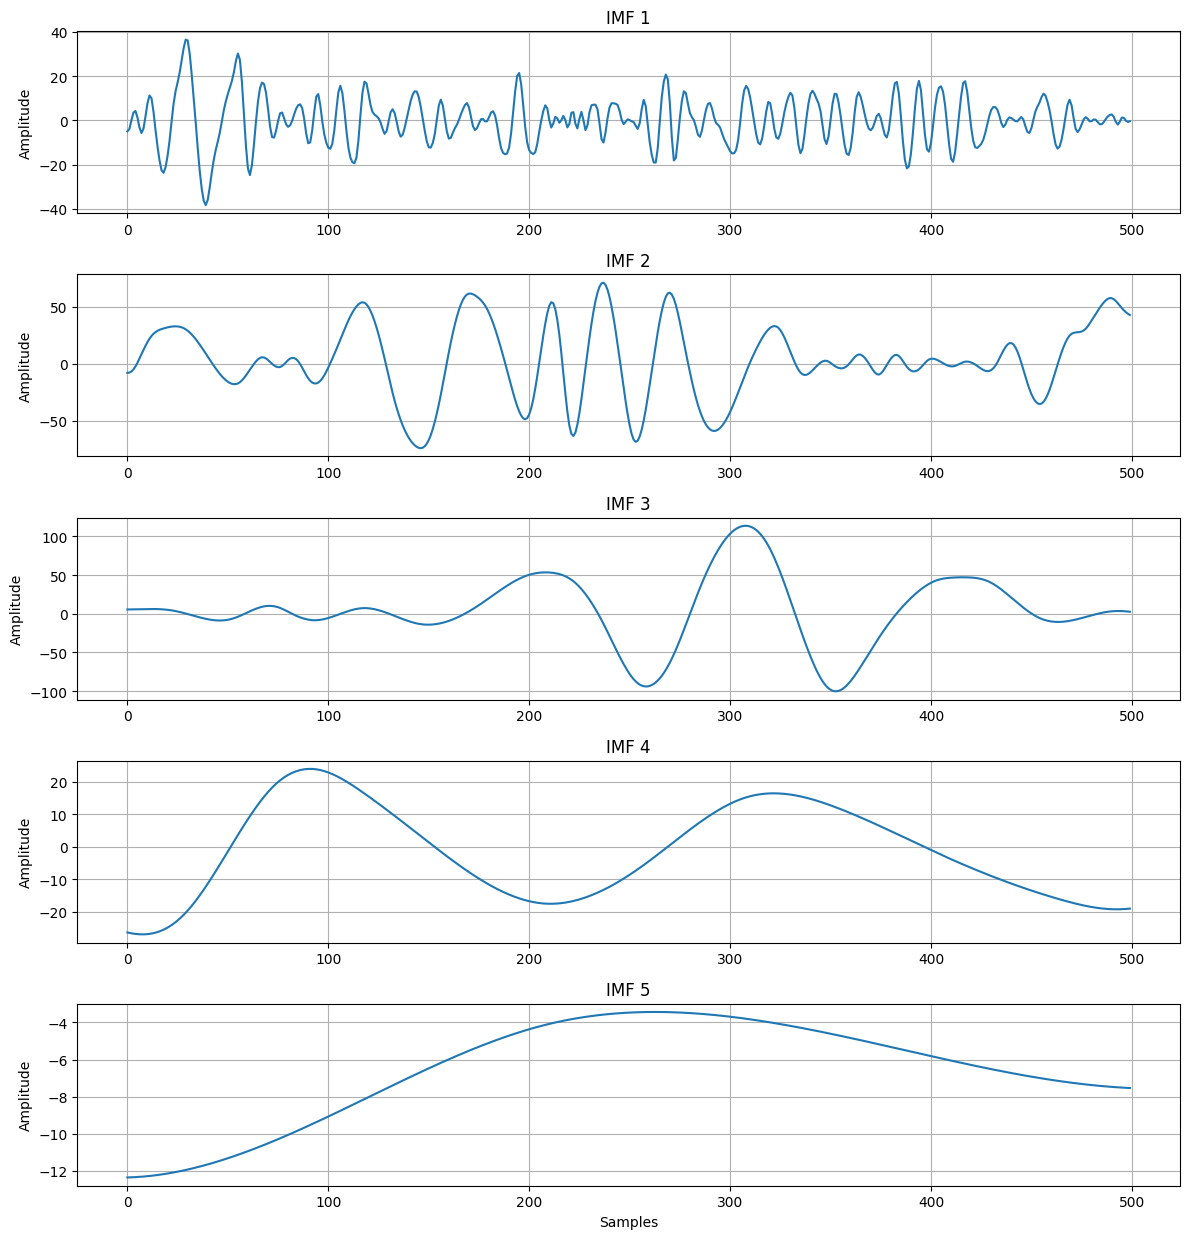

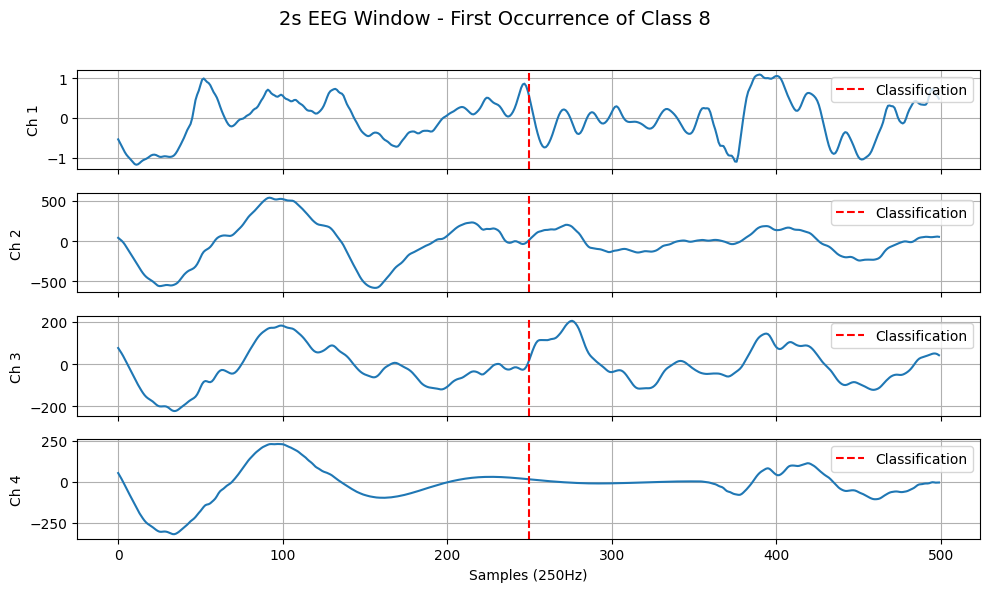

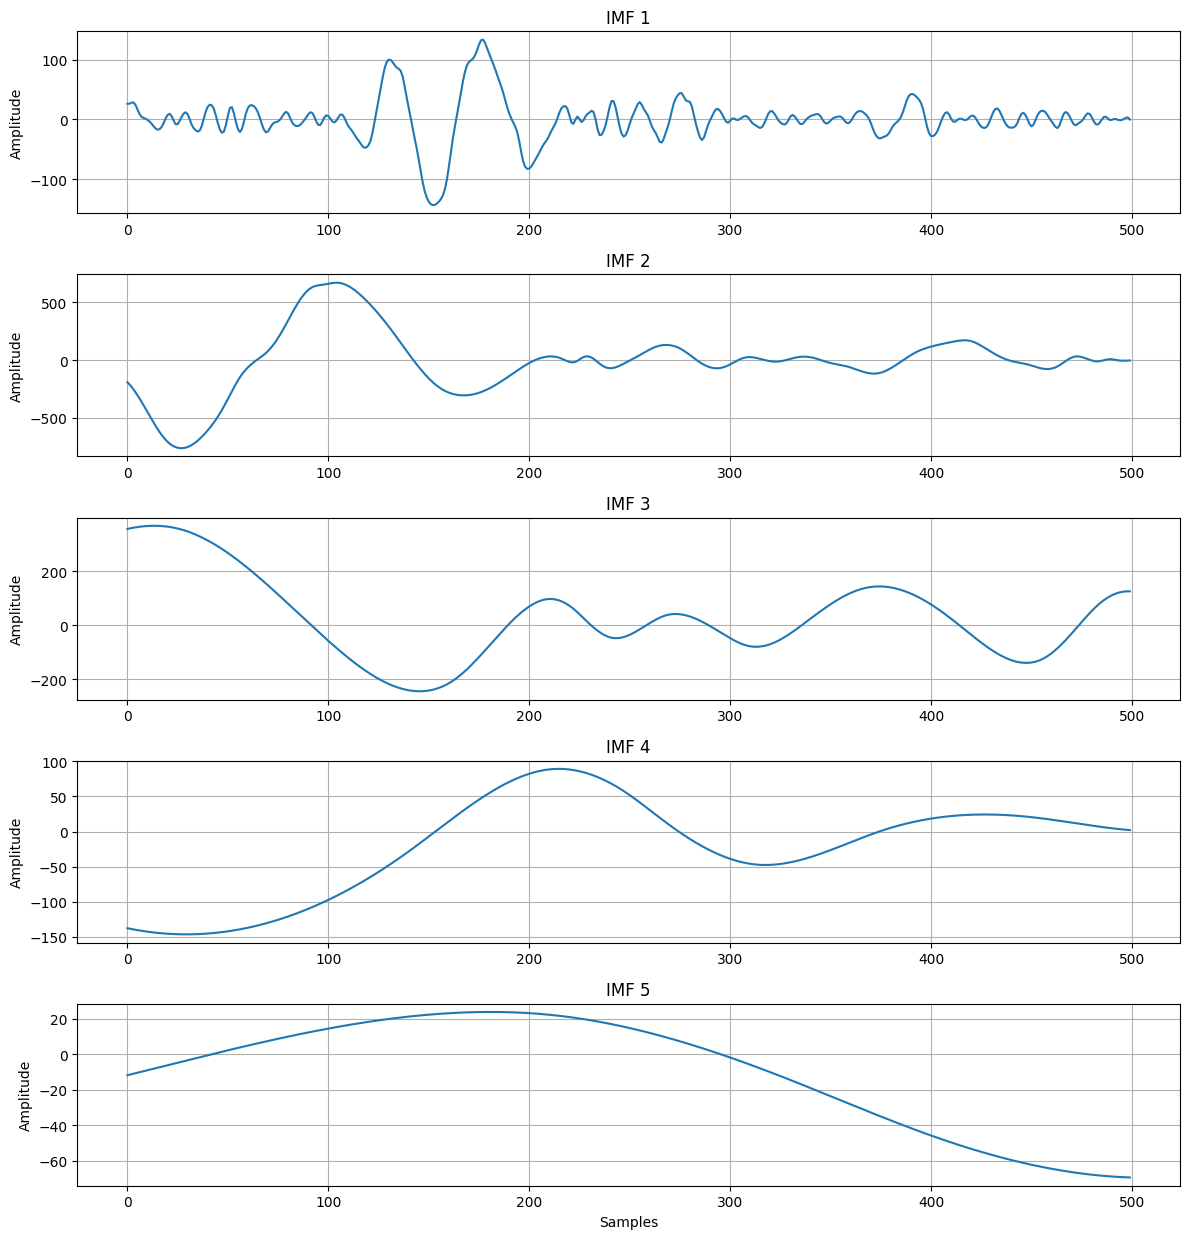

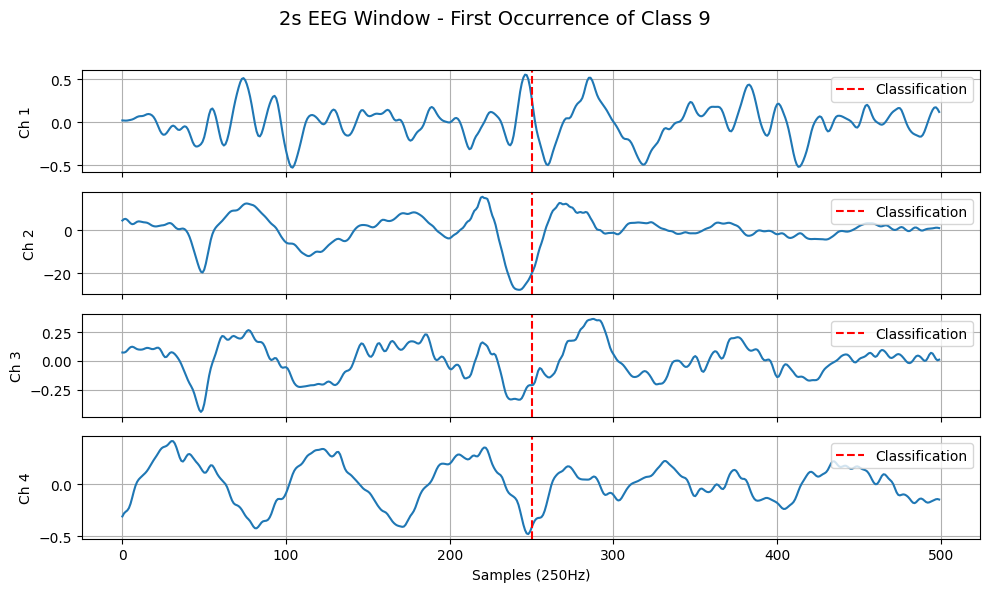

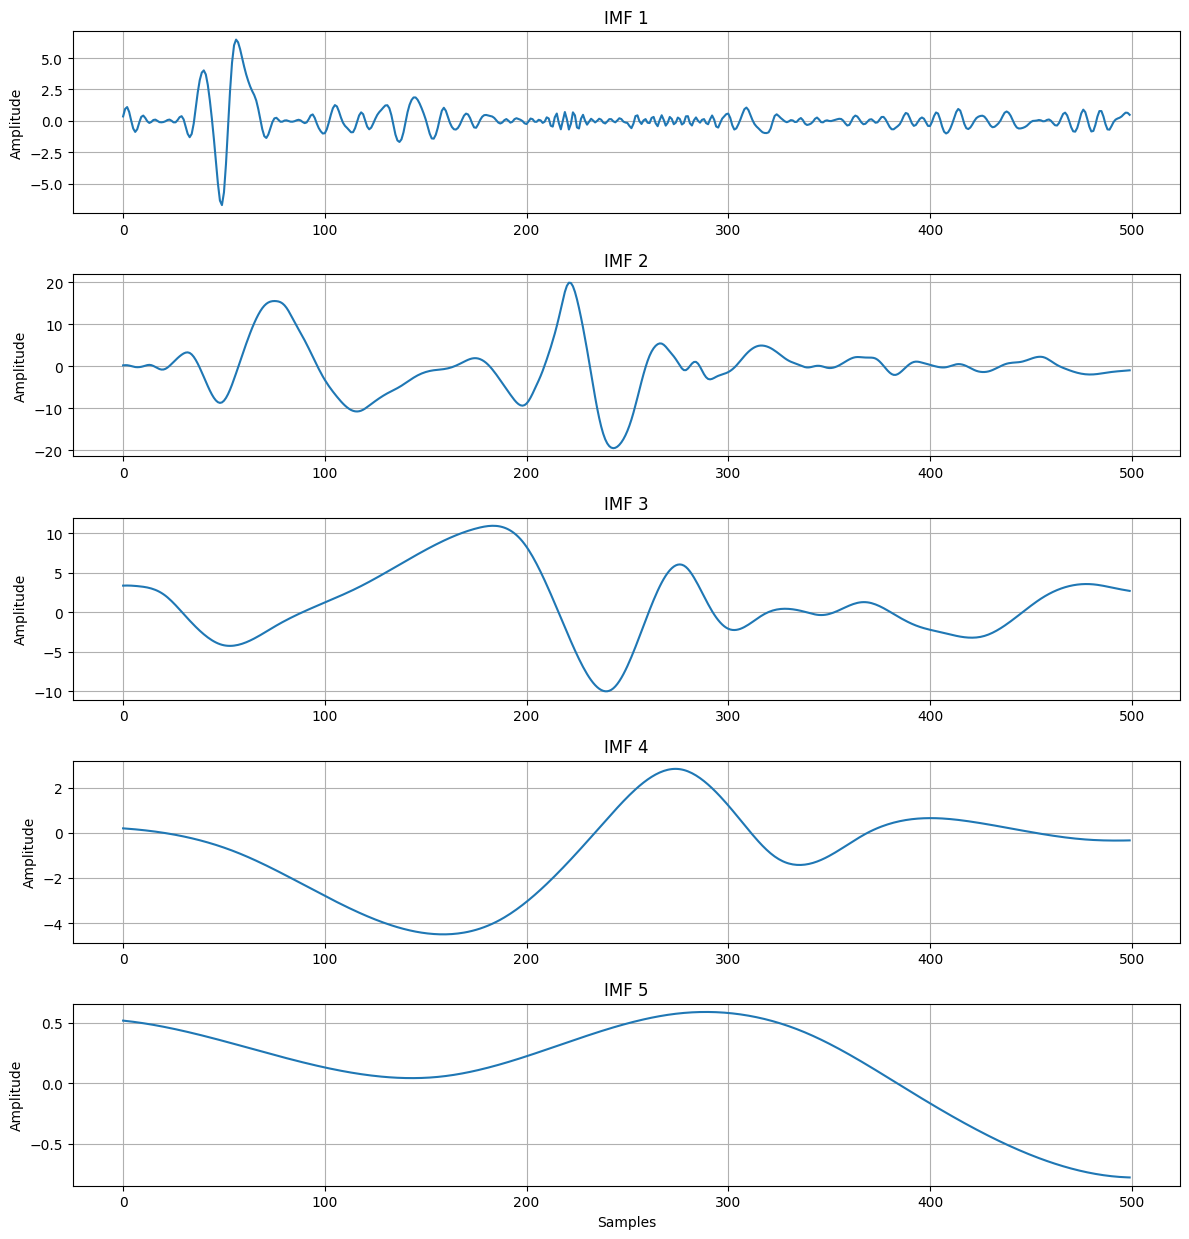

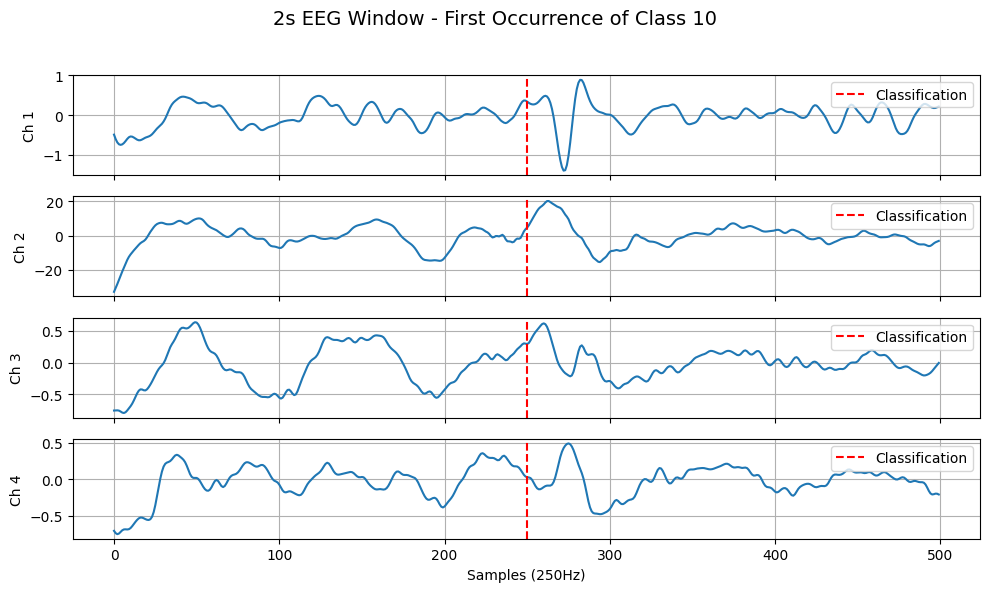

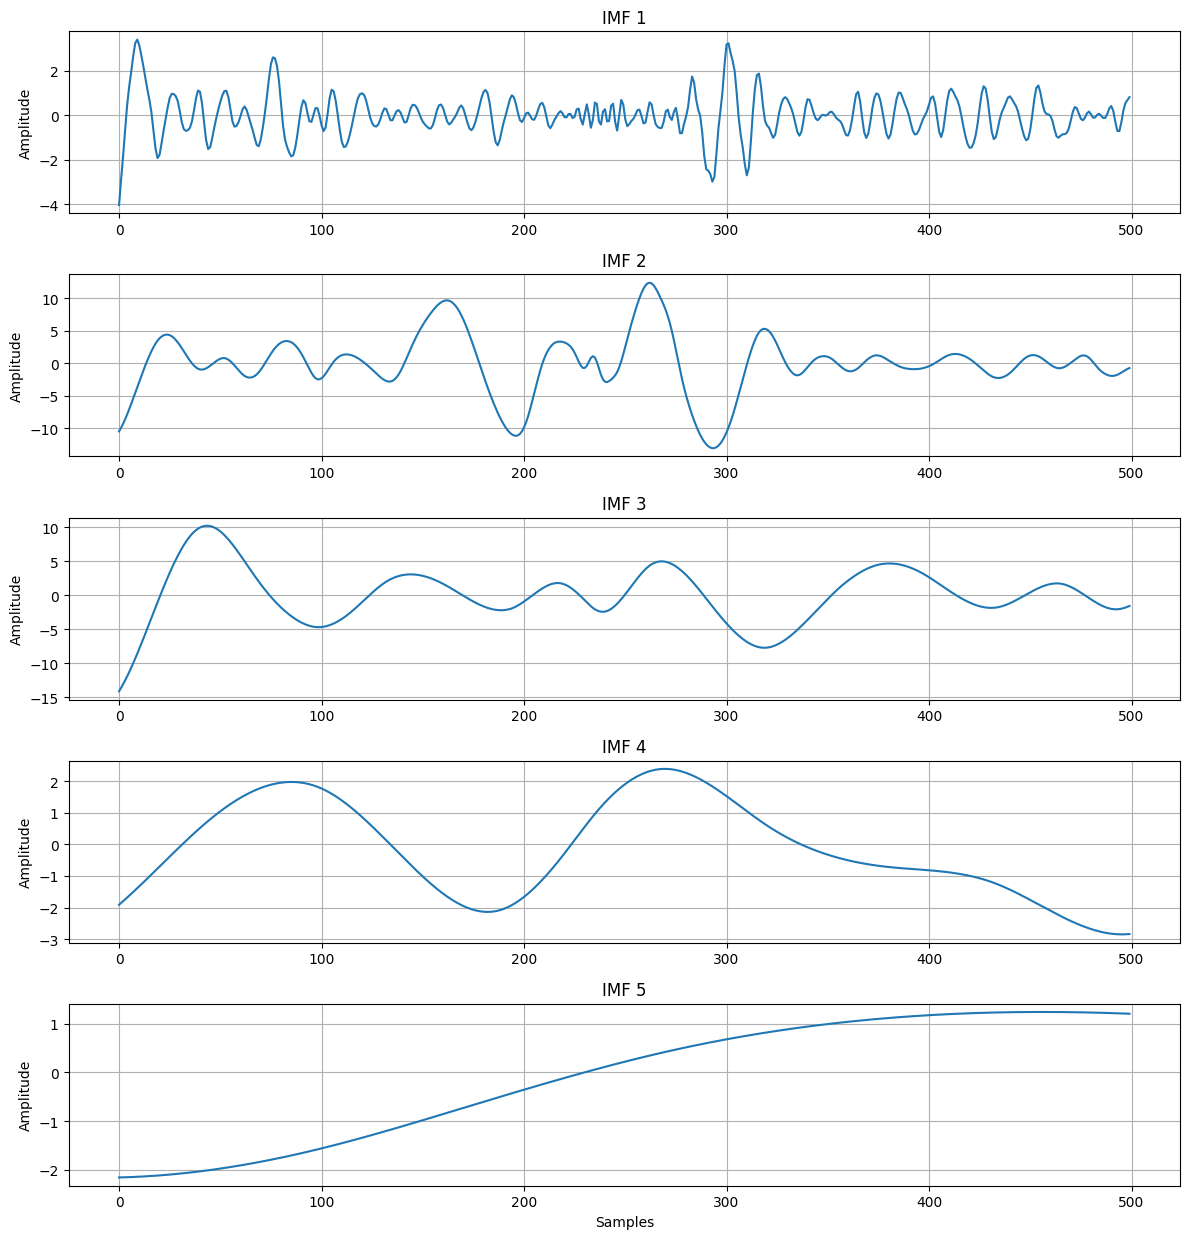

In [13]:
# Load files
classification_path = "TrainingData/training_data.csv"
data_path = "TrainingData/combined_data.csv"

classification = pd.read_csv(classification_path).values.astype(np.int64)
data = pd.read_csv(data_path).values.astype(np.float32)

# EEG & class info
channel_data = data[:, :4]
classifications_list = [0,1,2,3,4,5,6,7,8,9,10]

# Settings
sampling_rate = 250
window_size = sampling_rate * 2  # 2 seconds
half_window = window_size // 2

# Plot each class
for class_id in classifications_list:
    matches = classification[classification[:, 0] == class_id]
    if len(matches) == 0:
        print(f"Class {class_id} not found in classification data.")
        continue

    center_idx = matches[12, 1]
    start = max(0, center_idx - half_window)
    end = min(len(data), center_idx + half_window)
    window = channel_data[start:end]
    

    
    #max_abs = np.max(np.abs(window))
    #window = window / max_abs if max_abs != 0 else window

    # Plot
    fig, axes = plt.subplots(4, 1, figsize=(10, 6), sharex=True)
    fig.suptitle(f"2s EEG Window - First Occurrence of Class {class_id}", fontsize=14)

    for ch in range(4):
        axes[ch].plot(window[:, ch], color='tab:blue')
        axes[ch].axvline(x=half_window, color='red', linestyle='--', label='Classification')  # vertical line
        axes[ch].set_ylabel(f"Ch {ch+1}")
        axes[ch].grid(True)
        axes[ch].legend(loc="upper right")

    axes[-1].set_xlabel("Samples (250Hz)")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    
    # Apply EMD
    emd = EMD()
    imfs = emd(window[:,1])  # Shape: (n_imfs, signal_length)

    # Plot IMFs
    n_imfs = imfs.shape[0]
    plt.figure(figsize=(12, 2.5 * n_imfs))

    for i in range(n_imfs):
        plt.subplot(n_imfs, 1, i + 1)
        plt.plot(imfs[i], color='tab:blue')
        plt.title(f"IMF {i + 1}")
        plt.ylabel("Amplitude")
        plt.grid(True)

    plt.xlabel("Samples")
    plt.tight_layout()
    plt.show()
    

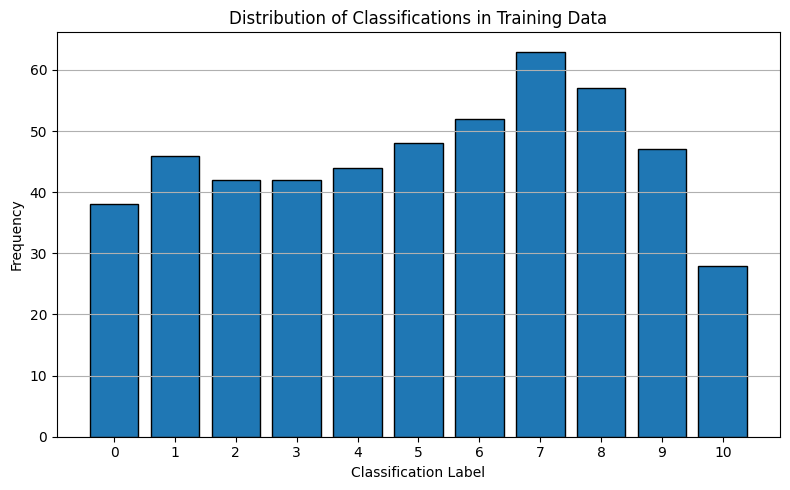

In [17]:
# Plot each class
# Load classification data
classification_path = "NickTrainingData/training_data.csv"
classification = pd.read_csv(classification_path).values.astype(np.int64)

# Extract class labels from the first column
class_labels = classification[:, 0]

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(class_labels, bins=np.arange(12) - 0.5, edgecolor='black', rwidth=0.8)
plt.xticks(range(11))
plt.xlabel("Classification Label")
plt.ylabel("Frequency")
plt.title("Distribution of Classifications in Training Data")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

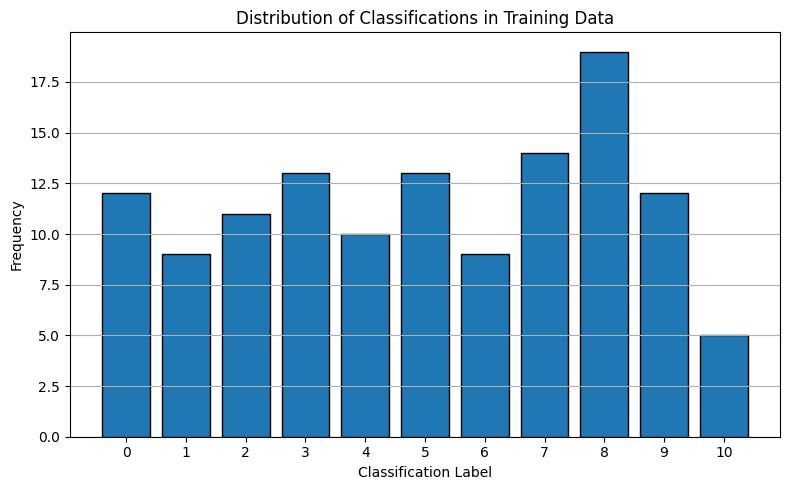

In [18]:
classification_path = "NickTrainingData/testing_data.csv"
classification = pd.read_csv(classification_path).values.astype(np.int64)

# Extract class labels from the first column
class_labels = classification[:, 0]

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(class_labels, bins=np.arange(12) - 0.5, edgecolor='black', rwidth=0.8)
plt.xticks(range(11))
plt.xlabel("Classification Label")
plt.ylabel("Frequency")
plt.title("Distribution of Classifications in Training Data")
plt.grid(axis='y')
plt.tight_layout()
plt.show()